In [1]:
!pip install nltk

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

In [3]:
# reading the dataset
data = pd.read_csv('/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv')

In [4]:
data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
data['text'][0]

'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.'

In [6]:
len(data)

40000

In [7]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# Initialize stemmer and stopwords
stemmer = PorterStemmer()

stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Optional: Apply stemming
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

In [9]:
# Apply preprocessing to the reviews column
data['tokens'] = data['text'].apply(preprocess)

In [10]:
# Check the tokenized result
data[['text', 'tokens']].head()

,text,tokens
0,I grew up (b. 1965) watching and loving the Th...,"[grew, b, 1965, watch, love, thunderbird, mate..."
1,"When I put this movie in my DVD player, and sa...","[put, movi, dvd, player, sat, coke, chip, expe..."
2,Why do people who do not know what a particula...,"[peopl, know, particular, time, past, like, fe..."
3,Even though I have great interest in Biblical ...,"[even, though, great, interest, biblic, movi, ..."
4,Im a die hard Dads Army fan and nothing will e...,"[im, die, hard, dad, armi, fan, noth, ever, ch..."


In [11]:
from collections import Counter
import numpy as np

In [12]:
# Create a vocabulary from the entire dataset (all tokens)
all_tokens = [token for tokens in data['tokens'] for token in tokens]
vocab = Counter(all_tokens)

# Limit the vocabulary size (optional)
MAX_VOCAB_SIZE = 25000
vocab = dict(vocab.most_common(MAX_VOCAB_SIZE - 1))  # Include the <unk> token
vocab['<unk>'] = 0  # Add an unknown token for out-of-vocabulary words

# Create a word-to-index mapping
word2idx = {word: idx for idx, (word, _) in enumerate(vocab.items())}

# Convert tokens to numerical indices
def tokens_to_indices(tokens):
    return [word2idx.get(token, word2idx['<unk>']) for token in tokens]

# Apply to all reviews
data['indexed'] = data['tokens'].apply(tokens_to_indices)

# Check the result
print(data[['tokens', 'indexed']].head())

                                              tokens  \
0  [grew, b, 1965, watch, love, thunderbird, mate...   
1  [put, movi, dvd, player, sat, coke, chip, expe...   
2  [peopl, know, particular, time, past, like, fe...   
3  [even, though, great, interest, biblic, movi, ...   
4  [im, die, hard, dad, armi, fan, noth, ever, ch...   

                                             indexed  
0  [1912, 895, 6637, 11, 25, 6197, 2437, 317, 11,...  
1  [141, 1, 198, 956, 1594, 5499, 4283, 153, 190,...  
2  [22, 37, 756, 5, 447, 4, 62, 125, 51, 1996, 5,...  
3  [12, 76, 24, 70, 4671, 1, 193, 246, 87, 111, 1...  
4  [69, 264, 199, 1141, 1075, 122, 82, 55, 255, 1...  


In [13]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Define padding function to pad sequences to the same length
def pad_sequences(sequences, max_len):
    padded_sequences = [seq[:max_len] if len(seq) > max_len else seq + [0] * (max_len - len(seq)) for seq in sequences]
    return torch.tensor(padded_sequences)

# Define maximum sequence length (you can tune this value)
MAX_SEQUENCE_LENGTH = 500

# Pad all sequences to the same length
padded_data = pad_sequences(data['indexed'], MAX_SEQUENCE_LENGTH)

# Check the padded data
print(padded_data.shape)  # (num_samples, MAX_SEQUENCE_LENGTH)

torch.Size([40000, 500])


In [14]:
# Convert to tensor
labels = torch.tensor(data['label'].values)

# Check the labels
print(labels[:10])  # First 10 labels

tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 1])


In [15]:
trainig_size = int(0.7*40000)
print(trainig_size)

28000


In [16]:
from torch.utils.data import DataLoader, TensorDataset

# Create TensorDataset
trainig_dataset = TensorDataset(padded_data[0:28000], labels[0:28000])
testing_dataset = TensorDataset(padded_data[28000:-1], labels[28000:-1])

# Create DataLoader (batch size of 64)
batch_size = 64
train_loader = DataLoader(trainig_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

In [25]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(RNN, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)  # Initialize embeddings

        # RNN weights
        self.Wxh = nn.Parameter(torch.empty(embedding_dim, hidden_dim))
        self.Whh = nn.Parameter(torch.empty(hidden_dim, hidden_dim))
        self.bh = nn.Parameter(torch.zeros(hidden_dim))

        # Output weights
        self.Why = nn.Parameter(torch.empty(hidden_dim, output_dim))
        self.by = nn.Parameter(torch.zeros(output_dim))

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        nn.init.xavier_uniform_(self.Wxh)
        nn.init.orthogonal_(self.Whh)
        nn.init.xavier_uniform_(self.Why)

    def forward(self, x):
        x_embedded = self.embedding(x)
        h = torch.zeros(x.size(0), self.Whh.size(0)).to(x.device)

        for t in range(x_embedded.size(1)):
            xt = x_embedded[:, t, :]
            h = torch.tanh(torch.matmul(xt, self.Wxh) + torch.matmul(h, self.Whh) + self.bh)

        h = self.dropout(h)  # Apply dropout to the hidden state
        out = torch.matmul(h, self.Why) + self.by
        return out

In [26]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(LSTM, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)  # Initialize embeddings

        # LSTM weights
        self.Wxi = nn.Parameter(torch.empty(embedding_dim, hidden_dim))
        self.Whi = nn.Parameter(torch.empty(hidden_dim, hidden_dim))
        self.bi = nn.Parameter(torch.zeros(hidden_dim))

        self.Wxf = nn.Parameter(torch.empty(embedding_dim, hidden_dim))
        self.Whf = nn.Parameter(torch.empty(hidden_dim, hidden_dim))
        self.bf = nn.Parameter(torch.zeros(hidden_dim))

        self.Wxc = nn.Parameter(torch.empty(embedding_dim, hidden_dim))
        self.Whc = nn.Parameter(torch.empty(hidden_dim, hidden_dim))
        self.bc = nn.Parameter(torch.zeros(hidden_dim))

        self.Wxo = nn.Parameter(torch.empty(embedding_dim, hidden_dim))
        self.Who = nn.Parameter(torch.empty(hidden_dim, hidden_dim))
        self.bo = nn.Parameter(torch.zeros(hidden_dim))

        # Output weights
        self.Why = nn.Parameter(torch.empty(hidden_dim, output_dim))
        self.by = nn.Parameter(torch.zeros(output_dim))

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        for param in [self.Wxi, self.Whi, self.Wxf, self.Whf, self.Wxc, self.Whc, self.Wxo, self.Who, self.Why]:
            nn.init.xavier_uniform_(param)

    def forward(self, x):
        x_embedded = self.embedding(x)  # Shape: [batch_size, seq_len, embedding_dim]
        h = torch.zeros(x.size(0), self.Why.size(0)).to(x.device)  # Hidden state
        c = torch.zeros(x.size(0), self.Why.size(0)).to(x.device)  # Cell state

        for t in range(x_embedded.size(1)):
            xt = x_embedded[:, t, :]
            i = torch.sigmoid(torch.matmul(xt, self.Wxi) + torch.matmul(h, self.Whi) + self.bi)
            f = torch.sigmoid(torch.matmul(xt, self.Wxf) + torch.matmul(h, self.Whf) + self.bf)
            g = torch.tanh(torch.matmul(xt, self.Wxc) + torch.matmul(h, self.Whc) + self.bc)
            o = torch.sigmoid(torch.matmul(xt, self.Wxo) + torch.matmul(h, self.Who) + self.bo)

            c = f * c + i * g  # Update cell state
            h = o * torch.tanh(c)  # Update hidden state

        h = self.dropout(h)  # Apply dropout to the hidden state
        out = torch.matmul(h, self.Why) + self.by
        return out

In [27]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(GRU, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)  # Initialize embeddings

        # GRU weights
        self.Wxr = nn.Parameter(torch.empty(embedding_dim, hidden_dim))  # Reset gate
        self.Whr = nn.Parameter(torch.empty(hidden_dim, hidden_dim))
        self.br = nn.Parameter(torch.zeros(hidden_dim))

        self.Wxz = nn.Parameter(torch.empty(embedding_dim, hidden_dim))  # Update gate
        self.Whz = nn.Parameter(torch.empty(hidden_dim, hidden_dim))
        self.bz = nn.Parameter(torch.zeros(hidden_dim))

        self.Wxh = nn.Parameter(torch.empty(embedding_dim, hidden_dim))  # Candidate hidden state
        self.Whh = nn.Parameter(torch.empty(hidden_dim, hidden_dim))
        self.bh = nn.Parameter(torch.zeros(hidden_dim))

        # Output weights
        self.Why = nn.Parameter(torch.empty(hidden_dim, output_dim))
        self.by = nn.Parameter(torch.zeros(output_dim))

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        for param in [self.Wxr, self.Whr, self.Wxz, self.Whz, self.Wxh, self.Whh, self.Why]:
            nn.init.xavier_uniform_(param)

    def forward(self, x):
        x_embedded = self.embedding(x)  # Shape: [batch_size, seq_len, embedding_dim]
        h = torch.zeros(x.size(0), self.Why.size(0)).to(x.device)  # Hidden state

        for t in range(x_embedded.size(1)):
            xt = x_embedded[:, t, :]
            r = torch.sigmoid(torch.matmul(xt, self.Wxr) + torch.matmul(h, self.Whr) + self.br)
            z = torch.sigmoid(torch.matmul(xt, self.Wxz) + torch.matmul(h, self.Whz) + self.bz)
            h_tilde = torch.tanh(torch.matmul(xt, self.Wxh) + torch.matmul(r * h, self.Whh) + self.bh)
            h = (1 - z) * h + z * h_tilde  # Update hidden state

        h = self.dropout(h)  # Apply dropout to the hidden state
        out = torch.matmul(h, self.Why) + self.by
        return out

In [31]:
# Function to train a model and collect metrics
def train_model(model, train_loader, test_loader, optimizer, loss_fn, n_epochs=5, model_name="Model"):
    train_losses, test_losses = [], []
    train_acc, test_acc = [] , []
    train_times = []

    print(f"\nTraining {model_name}...\n")
    for epoch in range(n_epochs):
        model.train()
        start_time = time.time()

        running_loss, correct_preds, total_preds = 0.0, 0, 0
        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_preds / total_preds * 100
        train_acc.append(train_accuracy)
        train_times.append(time.time() - start_time)

        model.eval()
        running_loss, correct_preds, total_preds = 0.0, 0, 0
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        avg_test_loss = running_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracy = correct_preds / total_preds * 100
        test_acc.append(test_accuracy)

        print(
            f"Epoch {epoch+1}/{n_epochs} - {model_name}\n"
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%\n"
            f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n"
        )

    return train_losses, test_losses, train_acc, test_acc, train_times


In [32]:
# Hyperparameters
EMBEDDING_DIM = 100  # Dimensionality of word embeddings
HIDDEN_DIM = 128    # Number of hidden units in the RNN
OUTPUT_DIM = 2      # Binary classification (positive/negative)
DROPOUT = 0.5       # Dropout rate

# Initialize models
rnn_model = RNN(vocab_size=len(word2idx), embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, dropout=DROPOUT).to(device)
lstm_model = LSTM(vocab_size=len(word2idx), embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, dropout=DROPOUT).to(device)
gru_model = GRU(vocab_size=len(word2idx), embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, dropout=DROPOUT).to(device)

# Optimizers
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

In [33]:
# Train RNN
rnn_results = train_model(
    model=rnn_model, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    optimizer=rnn_optimizer, 
    loss_fn=loss_fn, 
    n_epochs=5, 
    model_name="RNN"
)

# Train LSTM
lstm_results = train_model(
    model=lstm_model, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    optimizer=lstm_optimizer, 
    loss_fn=loss_fn, 
    n_epochs=5, 
    model_name="LSTM"
)

# Train GRU
gru_results = train_model(
    model=gru_model, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    optimizer=gru_optimizer, 
    loss_fn=loss_fn, 
    n_epochs=5, 
    model_name="GRU"
)


Training RNN...

Epoch 1/5 - RNN
Train Loss: 0.7485, Train Accuracy: 49.71%
Test Loss: 0.6980, Test Accuracy: 49.80%

Epoch 2/5 - RNN
Train Loss: 0.7006, Train Accuracy: 50.20%
Test Loss: 0.6958, Test Accuracy: 49.51%

Epoch 3/5 - RNN
Train Loss: 0.6992, Train Accuracy: 49.93%
Test Loss: 0.6934, Test Accuracy: 50.00%

Epoch 4/5 - RNN
Train Loss: 0.6974, Train Accuracy: 50.59%
Test Loss: 0.6994, Test Accuracy: 50.80%

Epoch 5/5 - RNN
Train Loss: 0.6971, Train Accuracy: 50.92%
Test Loss: 0.6953, Test Accuracy: 50.24%


Training LSTM...

Epoch 1/5 - LSTM
Train Loss: 0.6942, Train Accuracy: 50.00%
Test Loss: 0.6939, Test Accuracy: 50.05%

Epoch 2/5 - LSTM
Train Loss: 0.6936, Train Accuracy: 49.78%
Test Loss: 0.6941, Test Accuracy: 49.93%

Epoch 3/5 - LSTM
Train Loss: 0.6932, Train Accuracy: 50.53%
Test Loss: 0.6932, Test Accuracy: 49.90%

Epoch 4/5 - LSTM
Train Loss: 0.6912, Train Accuracy: 50.88%
Test Loss: 0.6956, Test Accuracy: 49.91%

Epoch 5/5 - LSTM
Train Loss: 0.6924, Train Accurac

In [34]:
# Unpack results
rnn_train_losses, rnn_test_losses, rnn_train_acc, rnn_test_acc, rnn_times = rnn_results
lstm_train_losses, lstm_test_losses, lstm_train_acc, lstm_test_acc, lstm_times = lstm_results
gru_train_losses, gru_test_losses, gru_train_acc, gru_test_acc, gru_times = gru_results

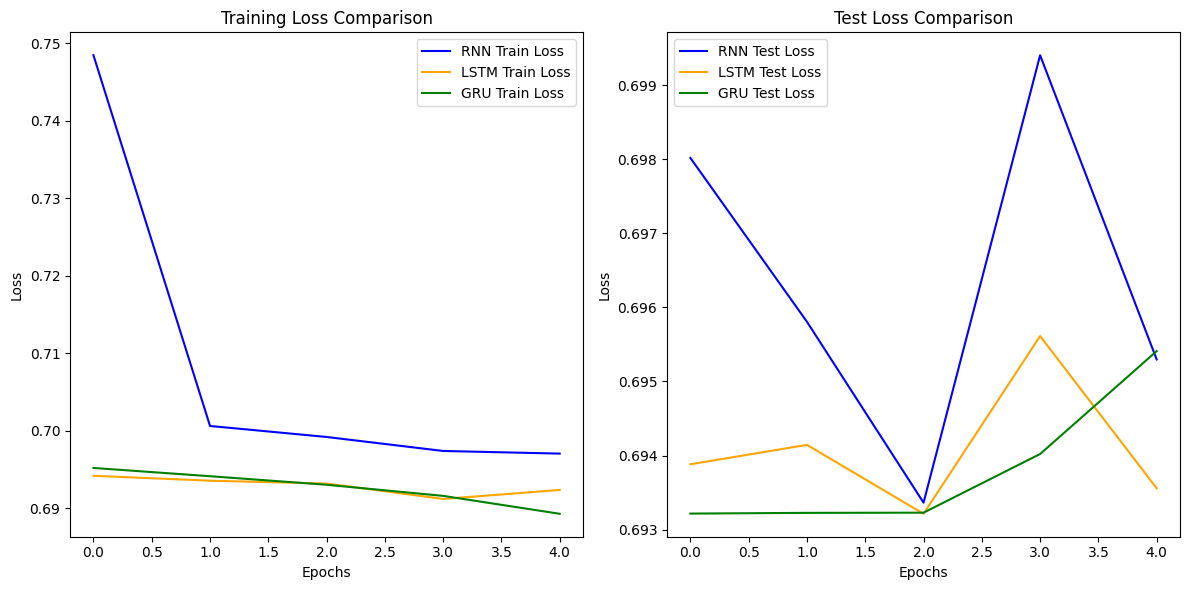

In [35]:
# Plot Loss Curves
plt.figure(figsize=(12, 6))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(rnn_train_losses, label="RNN Train Loss", color='blue')
plt.plot(lstm_train_losses, label="LSTM Train Loss", color='orange')
plt.plot(gru_train_losses, label="GRU Train Loss", color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()

# Test Loss
plt.subplot(1, 2, 2)
plt.plot(rnn_test_losses, label="RNN Test Loss", color='blue')
plt.plot(lstm_test_losses, label="LSTM Test Loss", color='orange')
plt.plot(gru_test_losses, label="GRU Test Loss", color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss Comparison')
plt.legend()

plt.tight_layout()
plt.show()

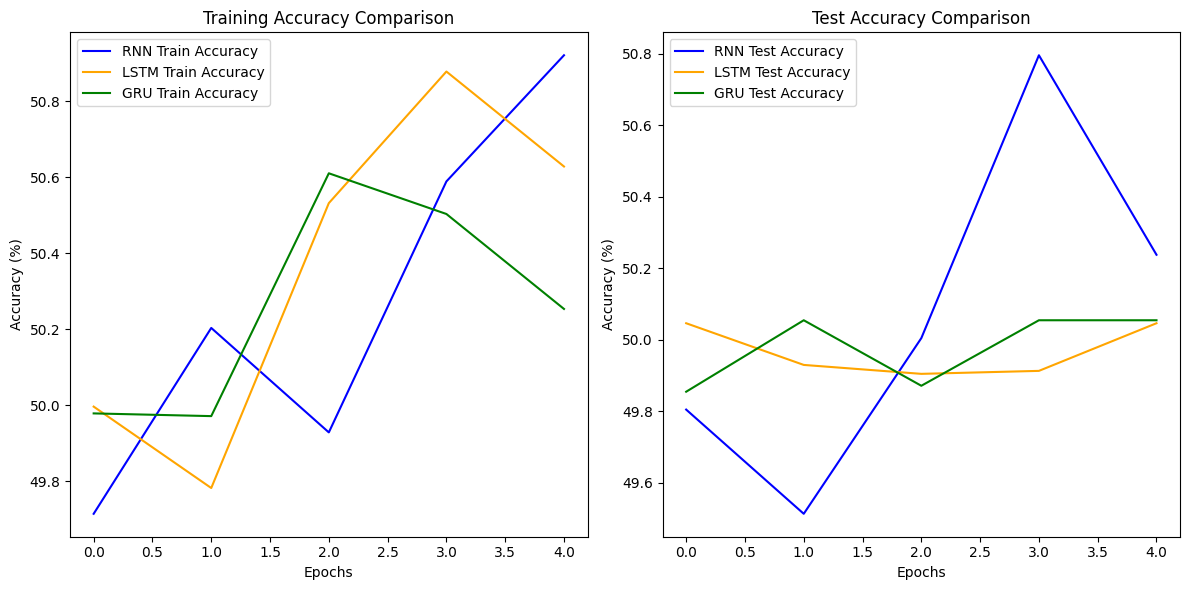

In [36]:
# Plot Accuracy
plt.figure(figsize=(12, 6))

# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(rnn_train_acc, label="RNN Train Accuracy", color='blue')
plt.plot(lstm_train_acc, label="LSTM Train Accuracy", color='orange')
plt.plot(gru_train_acc, label="GRU Train Accuracy", color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(rnn_test_acc, label="RNN Test Accuracy", color='blue')
plt.plot(lstm_test_acc, label="LSTM Test Accuracy", color='orange')
plt.plot(gru_test_acc, label="GRU Test Accuracy", color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()

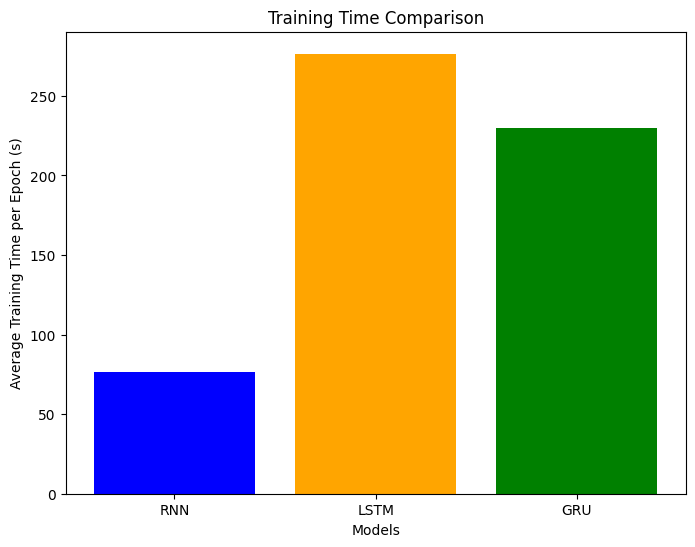

In [37]:
# Training Time Comparison
models = ['RNN', 'LSTM', 'GRU']
avg_times = [np.mean(rnn_times), np.mean(lstm_times), np.mean(gru_times)]

plt.figure(figsize=(8, 6))
plt.bar(models, avg_times, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Average Training Time per Epoch (s)')
plt.title('Training Time Comparison')
plt.show()